# Detección de Videos generados por medio de DeepFake

## Entrenamiento y Validación de los Modelos

Importación de las librerías necesarias.

In [3]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import json
import time
import pickle
from tqdm.notebook import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import random
from IPython.display import Video
import gcsfs as gcs

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

from keras.wrappers.scikit_learn import KerasClassifier
import keras_tuner as kt
import keras
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from keras.models import Model as KerasModel

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Conv2DTranspose
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
import torch
from tensorflow.keras.applications import InceptionV3, VGG16

import tensorflow_datasets as tfds

%matplotlib inline

## 1. Importación de los datos

Importación del archivo que contiene las rutas de los videos y las etiquetas del conjunto de datos definitivo.

In [7]:
data_def = pd.read_csv('data_definitiva.csv', sep = '|')
data_def = data_def.drop('Unnamed: 0', axis = 1)
data_def = data_def.values.tolist()

Clases a predecir.

In [8]:
classes = list(set([x[1] for x in data_def]))

Función para convertir los datos y dar el orden necesario a los canales RGB de las imágenes de los rostros extraídos a partir de los frames de los videos.

In [9]:
def process_image(images):
    n_images = len(images)
    f_shape = images[0].shape
    images_p = np.empty(shape = (n_images, f_shape[-2], f_shape[-1], f_shape[-3]), dtype = int)
    for i in range(n_images):
        images_p[i, :, :, :] = images[i][:,:,:].permute(1,2,0).int().numpy()
    return images_p    

Clase utilizada para la extracción de rostros en las imagenes extraídas del video.

In [10]:
class DetectionPipeline:

    def __init__(self, detector, n_frames=50):

        self.detector = detector
        self.n_frames = n_frames
        
    def __call__(self, filename):
 
   
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
        faces = []
        frames = []
        def_faces = []
        for j in range(v_len):
            success = v_cap.grab()
            success, frame = v_cap.retrieve()
            if not success:
                continue
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            frames.append(frame)
        
        idxs = [x for x in range(len(frames))]
        cond = True
        while cond:
            
            if len(idxs)>n_frames:
                slice_idxs =  random.sample(idxs, n_frames-len(def_faces))
                slice_idxs.sort()
                idxs = [x for x in idxs if x not in slice_idxs]
                sample = [frames[x] for x in slice_idxs]
                faces = self.detector(sample)
                temp_faces = [f for f in faces if f != None]
                def_faces.extend(temp_faces)
            else:
                def_faces.extend(frames)

            if len(def_faces)>=n_frames:
                cond = False
                def_faces = def_faces[:30]
        
        def_faces = process_image(def_faces)
        v_cap.release()
        
        return def_faces

Definición de la cantidad de frames a tomar del video y el tamaño final de las imágenes.

In [11]:
n_videos = len(data_def)
n_frames = 30
final_shape = (100, 100)

Validación del dispositivo donde va a ser ejecutado Torch.

In [12]:
torch_home = get_torch_home()

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


Creación del objeto Multi-task Cascaded Convolutional Networks para la detección de rostros en los frames del video.

In [13]:
mtcnn = MTCNN(image_size =final_shape[0] ,margin=14, factor=0.5, post_process = False).eval()

In [14]:
detection_pipeline = DetectionPipeline(detector=mtcnn, n_frames = n_frames)

## 2. Transformación de los datos

Creación de los arrays donde se va a incluir la información.

In [15]:
images = np.empty(shape = (n_videos, n_frames, final_shape[0], final_shape[1], 3), dtype=int)
labels = np.empty(shape = (n_videos), dtype = int)

In [16]:
intervals = [0, 799, 2398]

Importación de los archivos con extension pckl generados en la etapa de extracción de características. Esta importación se hace desde un bucket de GCS.

In [12]:
fs = gcs.GCSFileSystem(project='deepfake2021')

for idx in range(len(intervals)-1):
    f = fs.open('deepfake-dataset/images_part_{}.pckl'.format(idx+1), 'rb')
    s, e = intervals[idx], intervals[idx+1]
    images[s:e,:,:] = pickle.load(f)
    f.close()
    
    f = fs.open('deepfake-dataset/labels_{}.pckl'.format(idx+1), 'rb')
    s, e = intervals[idx], intervals[idx+1]
    labels[s:e] = pickle.load(f)
    f.close()

In [18]:
for idx in range(len(intervals)-1):
    f = open('images_part_{}.pckl'.format(idx+1), 'rb')
    s, e = intervals[idx], intervals[idx+1]
    images[s:e,:,:] = pickle.load(f)
    f.close()
    
    f = open('labels_{}.pckl'.format(idx+1), 'rb')
    s, e = intervals[idx], intervals[idx+1]
    labels[s:e] = pickle.load(f)
    f.close()

## 3. Exploración de los datos

Se carga un video de muestra para observar el conjunto de datos utilizado.

In [19]:
video_path = 'dataset/batch-04/zmciszomkw.mp4'
sample = detection_pipeline(video_path)

Video(video_path, height=600)

C:\Users\DanielBaron\anaconda3\envs\gpu_env\lib\site-packages\facenet_pytorch\models\utils\detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
C:\Users\DanielBaron\anaconda3\envs\gpu_env\lib\site-packages\facenet_pytorch\models\mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
C:\Users\DanielBaron\anaconda3\envs\gpu_env\lib\site-packages\facenet_pytorch\models\mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragge

A continuación, se observa el resultado del video anteriormente mostrado luego de la etapa de preprocesamiento y preparación de los datos. Como se puede observar, se extrajeron los rostros de cada frame del video de acuerdo a la cantidad de frames pasado por parámetro a la hora de construir el pipeline de detección de rostros.

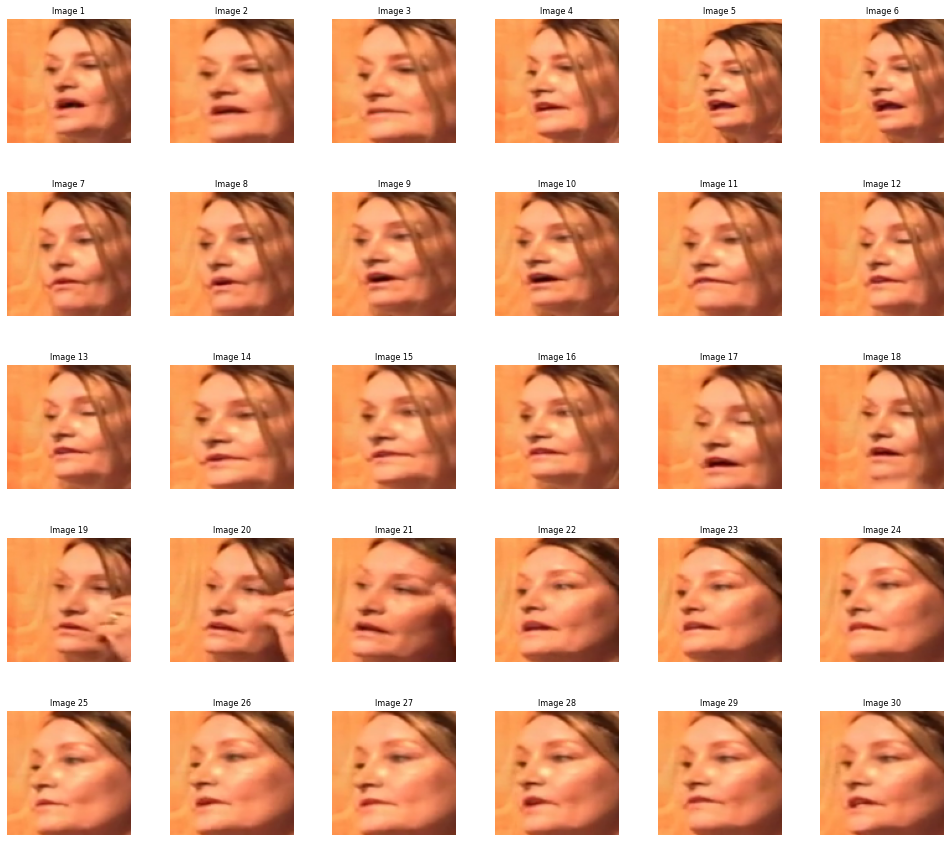

In [14]:
W_grid = 6
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,15))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    axes[i].imshow(sample[i,:,:], cmap ='gray')
    axes[i].set_title('Image {}'.format(i+1), fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

## Partición de los datos

Para realizar la división del dataset de entrenamiento y validación se utilizó solo la mitad de los datos debido a que fue lo máximo permitido por los recursos disponibles. Se intentó utilizar todos los datos disponibles pero se generaron errores de memoria a la hora de crear los modelos. Es por ende que la distribución de datos quedó de la siguiente manera:
- Conjunto de entrenamiento: 960 videos
- Conjunto de validación: 240 videos
- Conjunto de prueba: 300 videos

In [20]:
X_train_full, X_test, y_train_full, y_test = train_test_split(images, labels, test_size=0.5, stratify = labels)

Se eliminan las variables que no son necesarias para liberar la memoria.

In [21]:
del(images, labels)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify = y_train_full)

Se eliminan las variables que no son necesarias para liberar la memoria.

In [23]:
del(X_train_full, y_train_full)

### 3.1 Distribución de los datos del conjunto de entrenamiento

Text(0.5, 1.0, 'Distribución de los datos para el conjunto de datos de entrenamiento')

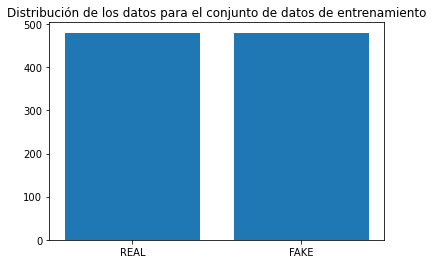

In [23]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique, ['REAL','FAKE'])
plt.title('Distribución de los datos para el conjunto de datos de entrenamiento')

### 3.2 Distribución de los datos del conjunto de validación

Text(0.5, 1.0, 'Distribución de los datos para el conjunto de datos de validación')

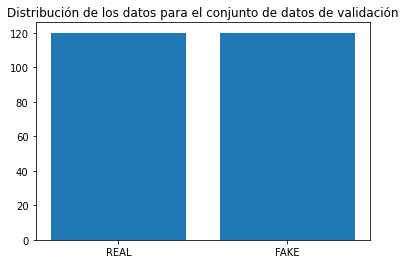

In [24]:
unique, counts = np.unique(y_val, return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique, ['REAL','FAKE'])
plt.title('Distribución de los datos para el conjunto de datos de validación')

### 3.3 Distribución de los datos del conjunto de prueba

Text(0.5, 1.0, 'Distribución de los datos para el conjunto de datos de prueba')

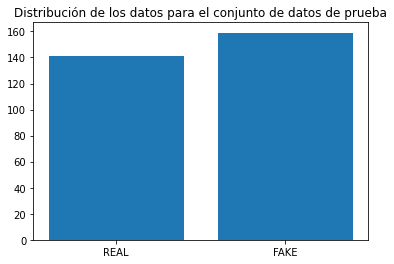

In [35]:
unique, counts = np.unique(y_test, return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique, ['REAL','FAKE'])
plt.title('Distribución de los datos para el conjunto de datos de prueba')

## 4. Modelamiento

Variables necesarias para la creación de los modelos.

In [25]:
shape = X_train.shape
n_images = shape[1]
i_width = shape[2]
i_height = shape[3]

Transformación de los conjuntos de entrenamiento, validación y prueba.

In [26]:
X_train = X_train.reshape(-1, n_frames*i_width, i_height, 3)/255
X_val = X_val.reshape(-1, n_frames*i_width, i_height, 3)/255
X_test = X_test.reshape(-1, n_frames*i_width, i_height, 3)/255

Transformación a variables categoricas de los datos etiquetados.

In [27]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

### 4.1 Modelo Baseline

Para el modelo baseline se utilizó una Red Convolucional simple. 

In [23]:
input_shape = X_train.shape[1:]
output_shape = len(np.unique(y_train))

Creación de la Red Convolucional a entrenar.

In [24]:
baseline_model = tf.keras.Sequential(
    name='Baseline_Model',
    layers=[
            tf.keras.layers.Conv2D(128, 2, padding='same', activation="relu", input_shape=input_shape),
            tf.keras.layers.MaxPooling2D((2,2), strides=1),
        
            tf.keras.layers.Conv2D(16, 2, padding='same', activation="relu"),
            tf.keras.layers.MaxPooling2D((2,2), strides=1),
        
            tf.keras.layers.Conv2D(8, 2, padding='same', activation="relu"),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dense(30, activation="relu"),
            tf.keras.layers.Dense(output_shape, activation="sigmoid")
     ]
)

2021-12-05 14:40:25.097533: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


A continuación se puede observar la arquitectura del modelo baseline.

In [25]:
baseline_model.summary()

Model: "Baseline_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3000, 100, 128)    1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2999, 99, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2999, 99, 16)      8208      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2998, 98, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2998, 98, 8)       520       
                                                                 
 flatten (Flatten)           (None, 2350432)        

Se utilizó el optimizador SGD con un Learning Rate de 0.0001

In [26]:
lr = 1e-4
baseline_model.compile(optimizer= SGD(learning_rate=lr), loss="categorical_crossentropy", metrics=['accuracy'])

In [27]:
early_stopping = EarlyStopping(monitor='loss', patience=5)
callbacks = [early_stopping]

In [28]:
baseline_model_history = baseline_model.fit(X_train,
                                            y_train,
                                            epochs=200,
                                            validation_data = (X_val,
                                                               y_val),
                                            callbacks=callbacks
                                           )

Epoch 1/200
30/30 [==============================] - 271s 9s/step - loss: 0.6938 - accuracy: 0.4828 - val_loss: 0.6914 - val_accuracy: 0.5500
Epoch 2/200
30/30 [==============================] - 270s 9s/step - loss: 0.6912 - accuracy: 0.5328 - val_loss: 0.6901 - val_accuracy: 0.5333
Epoch 3/200
30/30 [==============================] - 278s 9s/step - loss: 0.6901 - accuracy: 0.5422 - val_loss: 0.6891 - val_accuracy: 0.5583
Epoch 4/200
30/30 [==============================] - 278s 9s/step - loss: 0.6883 - accuracy: 0.5683 - val_loss: 0.6883 - val_accuracy: 0.5667
Epoch 5/200
30/30 [==============================] - 269s 9s/step - loss: 0.6866 - accuracy: 0.5527 - val_loss: 0.6864 - val_accuracy: 0.5583
Epoch 6/200
30/30 [==============================] - 270s 9s/step - loss: 0.6861 - accuracy: 0.5568 - val_loss: 0.6880 - val_accuracy: 0.5542
Epoch 7/200
30/30 [==============================] - 265s 9s/step - loss: 0.6856 - accuracy: 0.5547 - val_loss: 0.6854 - val_accuracy: 0.5708
Epoch 

Se guarda el modelo para evitar el reentrenamiento.

In [29]:
baseline_model.save("baseline_model.h5")

### 4.2 Modelo Creado a partir de la red Preentrenada InceptionV3

Se crea una un modelo a partir de la red Preentrenada InceptionV3 y se comparan los resultados con el modelo baseline. Para la arquitectura de este modelo se uso como base la arquitectura de la red preentrenada InceptionV3 y una etapa de clasificación que consiste en 2 capas con 512 y 256 neuronas respectivamente, ademas de una capa de GlobalAveragePooling y dos capas de Dropout para evitar el overfitting en el modelo.

In [38]:
base_model = InceptionV3(
    include_top=False,
    weights="imagenet", 
    input_shape=input_shape,
)

In [39]:
base_model.trainable = False
output_bm = base_model.output
flatten = Flatten()(output_bm)

In [40]:
class_layer = GlobalAveragePooling2D()(output_bm)
class_layer = Dense(512, activation = "relu")(class_layer)
class_layer = Dropout(0.1)(class_layer)
class_layer = Dense(256, activation = "relu")(class_layer)
class_layer = Dropout(0.1)(class_layer)
output_class = Dense(output_shape, activation ="sigmoid", name ='label')(class_layer)

In [41]:
pretrained_inceptionV3_model = Model(inputs=base_model.input, outputs=[output_class])

In [42]:
pretrained_inceptionV3_model.summary()

Model: "model_66"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_67 (InputLayer)          [(None, 3000, 100,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d_6204 (Conv2D)           (None, 1499, 49, 32  864         ['input_67[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_6204 (Batc  (None, 1499, 49, 32  96         ['conv2d_6204[0][0]']            
 hNormalization)                )                                                          

In [43]:
lr = 1e-3
optimizer = Adam(learning_rate=lr)

In [44]:
pretrained_inceptionV3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
early_stopping = EarlyStopping(monitor='loss', patience=5)
callbacks = [early_stopping]

In [47]:
pretrained_inceptionV3_model_history = pretrained_inceptionV3_model.fit(X_train,
                                                                        y_train,
                                                                        epochs=200,
                                                                        validation_data = (X_val,
                                                                                           y_val),
                                                                        callbacks=callbacks
                                                                       )

Epoch 1/200
30/30 [==============================] - 249s 8s/step - loss: 0.6568 - accuracy: 0.6392 - val_loss: 0.6429 - val_accuracy: 0.6792
Epoch 2/200
30/30 [==============================] - 250s 8s/step - loss: 0.5848 - accuracy: 0.6851 - val_loss: 0.6093 - val_accuracy: 0.6917
Epoch 3/200
30/30 [==============================] - 255s 9s/step - loss: 0.5500 - accuracy: 0.7185 - val_loss: 0.6038 - val_accuracy: 0.6833
Epoch 4/200
30/30 [==============================] - 252s 8s/step - loss: 0.4963 - accuracy: 0.7560 - val_loss: 0.5830 - val_accuracy: 0.7417
Epoch 5/200
30/30 [==============================] - 251s 8s/step - loss: 0.4851 - accuracy: 0.7570 - val_loss: 0.5941 - val_accuracy: 0.7000
Epoch 6/200
30/30 [==============================] - 253s 8s/step - loss: 0.4658 - accuracy: 0.7800 - val_loss: 0.6227 - val_accuracy: 0.7083
Epoch 7/200
30/30 [==============================] - 249s 8s/step - loss: 0.4529 - accuracy: 0.7914 - val_loss: 0.7356 - val_accuracy: 0.6875
Epoch 

Se guarda el modelo para evitar el reentrenamiento.

In [49]:
pretrained_inceptionV3_model.save("pretrained_inceptionV3_model.h5")

### 4.3 Modelo Creado a partir de la red Preentrenada VGG16

Ademas del modelo generado a partir de la red preentrenada, se construyó otro modelo a partir de la red preentrenada VGG16.

In [ ]:
vgg16_base_model = tf.keras.applications.VGG16(
            include_top=False,
            weights="imagenet",
            input_shape=input_shape
)

In [ ]:
vgg16_base_model.trainable = False
output_bm = vgg16_base_model.output
flatten = Flatten()(output_bm)

In [ ]:
class_layer = GlobalAveragePooling2D()(output_bm)
class_layer = Dense(512, activation = "relu")(class_layer)
class_layer = Dropout(0.1)(class_layer)
class_layer = Dense(256, activation = "relu")(class_layer)
class_layer = Dropout(0.1)(class_layer)
output_class = Dense(output_shape, activation ="sigmoid", name ='label')(class_layer)

In [ ]:
pretrained_vgg16_model = Model(inputs=vgg16_base_model.input, outputs=[output_class])

In [ ]:
pretrained_vgg16_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3000, 100, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 3000, 100, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 3000, 100, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 1500, 50, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 1500, 50, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 1500, 50, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 750, 25, 128)      0   

In [ ]:
lr = 1e-3
optimizer = Adam(learning_rate=lr)

In [ ]:
pretrained_vgg16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=5)
callbacks = [early_stopping]

In [ ]:
pretrained_vgg16_model_history = pretrained_vgg16_model.fit(X_train,
                                                            y_train,
                                                            epochs=200,
                                                            validation_data = (X_val,
                                                                               y_val),
                                                            callbacks=callbacks
                                                      )

Epoch 1/200
30/30 [==============================] - 932s 31s/step - loss: 0.7021 - accuracy: 0.5725 - val_loss: 0.7526 - val_accuracy: 0.5500
Epoch 2/200
30/30 [==============================] - 924s 31s/step - loss: 0.6127 - accuracy: 0.6601 - val_loss: 0.6555 - val_accuracy: 0.6167
Epoch 3/200
30/30 [==============================] - 920s 31s/step - loss: 0.5873 - accuracy: 0.7039 - val_loss: 0.6419 - val_accuracy: 0.6042
Epoch 4/200
30/30 [==============================] - 920s 31s/step - loss: 0.5626 - accuracy: 0.7091 - val_loss: 0.6907 - val_accuracy: 0.6375
Epoch 5/200
30/30 [==============================] - 917s 31s/step - loss: 0.5491 - accuracy: 0.6986 - val_loss: 0.6084 - val_accuracy: 0.6708
Epoch 6/200
30/30 [==============================] - 917s 31s/step - loss: 0.5223 - accuracy: 0.7278 - val_loss: 0.5969 - val_accuracy: 0.6792
Epoch 7/200
30/30 [==============================] - 918s 31s/step - loss: 0.5496 - accuracy: 0.7195 - val_loss: 0.6580 - val_accuracy: 0.6375

Se guarda el modelo para evitar el reentrenamiento.

In [ ]:
pretrained_vgg16_model.save("pretrained_vgg16_model.h5")

## 5. Medición del performance de los modelos en el conjunto de prueba

Cargar los modelos generados anteriormente.

In [ ]:
baseline_model = keras.models.load_model('baseline_model.h5')
pretrained_inceptionV3_model = keras.models.load_model('pretrained_inceptionV3_model.h5')
pretrained_vgg16_model = keras.models.load_model('pretrained_vgg16_model.h5')

Lista en donde se almacenaran los resultados en el conjunto de test para cada modelo.

In [31]:
resultados = []

### 5.1 Modelo Baseline

In [69]:
baseline_predicted = baseline_model.predict(X_test).argmax(axis=-1)

In [71]:
baseline_val = baseline_model.evaluate(X_val, y_val)
print('Validation loss: {:4f}\nValidation Accuracy: {:4f}'.format(baseline_val[0], baseline_val[1]))

8/8 [==============================] - 13s 2s/step - loss: 0.6175 - accuracy: 0.6958
Validation loss: 0.617546
Validation Accuracy: 0.695833


In [72]:
baseline_test = baseline_model.evaluate(X_test, y_test)
print('Test loss: {:4f}\nTest Accuracy: {:4f}'.format(baseline_test[0], baseline_test[1]))
resultados.append(['Modelo Baseline', baseline_test[0], baseline_test[1]])

10/10 [==============================] - 16s 2s/step - loss: 0.5856 - accuracy: 0.6700
Test loss: 0.585607
Test Accuracy: 0.670000


In [73]:
print('Reporte para el modelo construido')
print(classification_report(y_test.argmax(axis=-1), baseline_predicted))

Reporte para el modelo construido
              precision    recall  f1-score   support

           0       0.69      0.53      0.60       139
           1       0.66      0.80      0.72       161

    accuracy                           0.67       300
   macro avg       0.67      0.66      0.66       300
weighted avg       0.67      0.67      0.66       300



### 5.2 Modelo Creado a partir de la red Preentrenada InceptionV3

In [74]:
pretrained_inceptionV3_predicted = pretrained_inceptionV3_model.predict(X_test).argmax(axis=-1)

In [75]:
pretrained_inceptionV3_val = pretrained_inceptionV3_model.evaluate(X_val, y_val)
print('Validation loss: {:4f}\nValidation Accuracy: {:4f}'.format(pretrained_inceptionV3_val[0], pretrained_inceptionV3_val[1]))

8/8 [==============================] - 69s 8s/step - loss: 0.4842 - accuracy: 0.8500
Validation loss: 0.484163
Validation Accuracy: 0.850000


In [76]:
pretrained_inceptionV3_test = pretrained_inceptionV3_model.evaluate(X_test, y_test)
print('Test loss: {:4f}\nTest Accuracy: {:4f}'.format(pretrained_inceptionV3_test[0], pretrained_inceptionV3_test[1]))
resultados.append(['Modelo red Preentrenada InceptionV3', pretrained_inceptionV3_test[0], pretrained_inceptionV3_test[1]])

10/10 [==============================] - 62s 6s/step - loss: 0.5766 - accuracy: 0.8267
Test loss: 0.576620
Test Accuracy: 0.826667


In [78]:
print('Reporte para el modelo construido')
print(classification_report(y_test.argmax(axis=-1), pretrained_inceptionV3_predicted))

Reporte para el modelo construido
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       139
           1       0.85      0.82      0.84       161

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300



### 5.3 Modelo Creado a partir de la red Preentrenada VGG16

In [ ]:
pretrained_vgg16_predicted = pretrained_vgg16_model.predict(X_test).argmax(axis=-1)

In [ ]:
pretrained_vgg16_val = pretrained_vgg16_model.evaluate(X_val, y_val)
print('Validation loss: {:4f}\nValidation Accuracy: {:4f}'.format(pretrained_vgg16_val[0], pretrained_vgg16_val[1]))

In [81]:
pretrained_vgg16_test = pretrained_vgg16_model.evaluate(X_test, y_test)
print('Test loss: {:4f}\nTest Accuracy: {:4f}'.format(pretrained_vgg16_test[0], pretrained_vgg16_test[1]))
resultados.append(['Modelo red Preentrenada VGG16', pretrained_vgg16_test[0], pretrained_vgg16_test[1]])

10/10 [==============================] - 232s 23s/step - loss: 0.5247 - accuracy: 0.8333
Test loss: 0.524731
Test Accuracy: 0.833333


In [82]:
print('Reporte para el modelo construido')
print(classification_report(y_test.argmax(axis=-1), pretrained_vgg16_predicted))

Reporte para el modelo construido
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       139
           1       0.82      0.88      0.85       161

    accuracy                           0.83       300
   macro avg       0.84      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300



## 6. Resultados

In [83]:
resultados_df = pd.DataFrame(data = resultados, columns = ['MODELO', 'FUNCION_PERDIDA', 'EXACTITUD'])
pd.set_option('display.max_colwidth', None)
resultados_df.sort_values(by = ['EXACTITUD', 'FUNCION_PERDIDA'], ascending = [False, True])

,MODELO,FUNCION_PERDIDA,EXACTITUD
2,Modelo red Preentrenada VGG16,0.524731,0.833333
1,Modelo red Preentrenada InceptionV3,0.576620,0.826667
0,Modelo Baseline,0.585607,0.670000


De acuerdo a los resultados obtenidos anteriormente, el modelo que obtuvo mejores resultados a la hora de evaluarlo en el conjutno de prueba fue Modelo creado a partir de la red preentrenada VGG16. Obtuvo el menor valor de función de pérdida y el mayor valor de exactitud a la hora de compararlos con los demas modelos.

## 6.1 Matrices de confusión

### 6.1.1 Modelo Baseline

Text(0.5, 1.0, 'Matriz de confusión para el modelo Baseline')

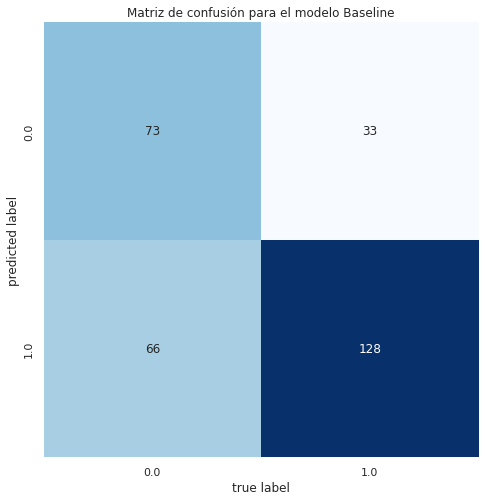

In [87]:
import seaborn as sns; sns.set()

plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.argmax(axis=-1), baseline_predicted)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Matriz de confusión para el modelo Baseline')

### 6.1.2 Modelo generado a partir de la red preentrenada InceptionV3

Text(0.5, 1.0, 'Matriz de confusión para la red preentrenada InceptionV3')

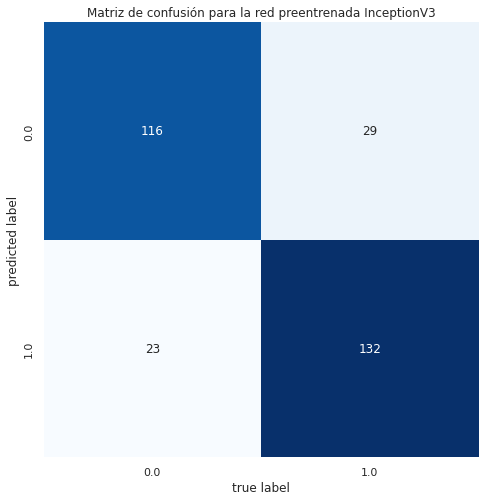

In [85]:
import seaborn as sns; sns.set()

plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.argmax(axis=-1), pretrained_inceptionV3_predicted)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Matriz de confusión para la red preentrenada InceptionV3')

### 6.1.3 Modelo generado a partir de la red preentrenada VGG16

In [ ]:
import seaborn as sns; sns.set()

plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.argmax(axis=-1), pretrained_vgg16_predicted)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=np.unique(y_test, dtype= int),
            yticklabels=np.unique(y_test, dtype= int))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Matriz de confusión para la red preentrenada VGG16')

Con base en los resultados anteriores, el modelo que presenta mejor desempeño es el Modelo creado a partir de la red preentrenada VGG16. Asimismo, este es el modelo escogido debido a que presenta un mejor desempeño en la clase de interés (clase FAKE). Para escoger el modelo se utilizó la métrica de RECALL, ya que para este problema de clasificación es más importante predecir la mayor cantidad de videos con posible etiqueta FAKE. 

Sin embargo, para obtener mejores resultados en el modelo es importante utilizar una cantidad mayor de datos en la etapa de entrenamiento, ya que debido a las limitaciones  de recursos no fue posible utilizar todos los datos disponibles.